<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ORDERNUMBER       2823 non-null   int64         
 1   QUANTITYORDERED   2823 non-null   int64         
 2   PRICEEACH         2823 non-null   float64       
 3   ORDERLINENUMBER   2823 non-null   int64         
 4   SALES             2823 non-null   float64       
 5   ORDERDATE         2823 non-null   datetime64[ns]
 6   STATUS            2823 non-null   object        
 7   QTR_ID            2823 non-null   int64         
 8   MONTH_ID          2823 non-null   int64         
 9   YEAR_ID           2823 non-null   int64         
 10  PRODUCTLINE       2823 non-null   object        
 11  MSRP              2823 non-null   int64         
 12  PRODUCTCODE       2823 non-null   object        
 13  CUSTOMERNAME      2823 non-null   object        
 14  PHONE             2823 n

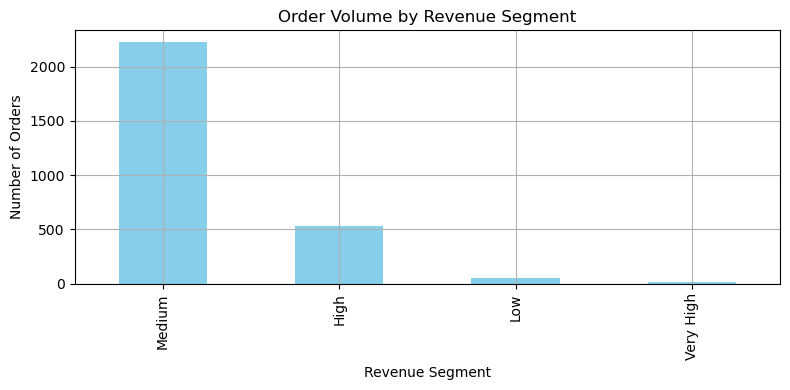

In [30]:
# Load with proper encoding and parse date column
import pandas as pd

df = pd.read_csv("sales_data_sample.csv", encoding="latin1", parse_dates=["ORDERDATE"])

# Explore data structure
print(df.info())
print(df["STATUS"].value_counts())
print(df.isnull().sum())  # Check nulls

# Drop unnecessary columns
df.drop(columns=["ADDRESSLINE2"], inplace=True)  # Mostly null

df["ORDER_YEAR"] = df["ORDERDATE"].dt.year
df["ORDER_MONTH"] = df["ORDERDATE"].dt.month
df["ORDER_QUARTER"] = df["ORDERDATE"].dt.quarter

df["UNIT_PROFIT"] = df["MSRP"] - df["PRICEEACH"]

# Optional: aggregate revenue per customer to segment later
df["REVENUE_SEGMENT"] = pd.cut(
    df["SALES"],
    bins=[0, 1000, 5000, 10000, df["SALES"].max()],
    labels=["Low", "Medium", "High", "Very High"]
)

df[["ORDERNUMBER", "SALES", "ORDER_YEAR", "ORDER_QUARTER", "UNIT_PROFIT", "REVENUE_SEGMENT"]].head()

import matplotlib.pyplot as plt

# Count of orders per revenue segment
df["REVENUE_SEGMENT"].value_counts().plot(
    kind="bar", 
    title="Order Volume by Revenue Segment", 
    xlabel="Revenue Segment", 
    ylabel="Number of Orders", 
    figsize=(8, 4), 
    color="skyblue"
)

plt.grid(True)
plt.tight_layout()
plt.show()

import sqlite3
import pandas as pd

conn = sqlite3.connect("sales_project.db")  # creates a file in your working directory
cursor = conn.cursor()

cursor.execute("""
CREATE TABLE IF NOT EXISTS Orders (
    ORDERNUMBER INTEGER PRIMARY KEY,
    ORDERDATE DATE,
    STATUS TEXT,
    SALES REAL,
    ORDER_YEAR INTEGER,
    ORDER_MONTH INTEGER,
    ORDER_QUARTER INTEGER,
    REVENUE_SEGMENT TEXT
);
""")

cursor.execute("""
CREATE TABLE IF NOT EXISTS OrderDetails (
    ORDERNUMBER INTEGER,
    PRODUCTCODE TEXT,
    QUANTITYORDERED INTEGER,
    PRICEEACH REAL,
    ORDERLINENUMBER INTEGER,
    MSRP REAL,
    UNIT_PROFIT REAL
);
""")

cursor.execute("""
CREATE TABLE IF NOT EXISTS Products (
    PRODUCTCODE TEXT PRIMARY KEY,
    PRODUCTLINE TEXT,
    DEALSIZE TEXT
);
""")

cursor.execute("""
CREATE TABLE IF NOT EXISTS Customers (
    CUSTOMERNAME TEXT PRIMARY KEY,
    CONTACTFIRSTNAME TEXT,
    CONTACTLASTNAME TEXT,
    PHONE TEXT,
    ADDRESSLINE1 TEXT,
    CITY TEXT,
    STATE TEXT,
    POSTALCODE TEXT,
    COUNTRY TEXT,
    TERRITORY TEXT
);
""")
conn.commit()

df.to_sql("Orders", conn, if_exists="replace", index=False)

df_details = df[[
    "ORDERNUMBER", "PRODUCTCODE", "QUANTITYORDERED", "PRICEEACH",
    "ORDERLINENUMBER", "MSRP", "UNIT_PROFIT"
]]
df_details.to_sql("OrderDetails", conn, if_exists="replace", index=False)

df_products = df[["PRODUCTCODE", "PRODUCTLINE", "DEALSIZE"]].drop_duplicates()
df_products.to_sql("Products", conn, if_exists="replace", index=False)

df_customers = df[[
    "CUSTOMERNAME", "CONTACTFIRSTNAME", "CONTACTLASTNAME", "PHONE",
    "ADDRESSLINE1", "CITY", "STATE", "POSTALCODE", "COUNTRY", "TERRITORY"
]].drop_duplicates()
df_customers.to_sql("Customers", conn, if_exists="replace", index=False)

pd.read_sql("SELECT * FROM Orders LIMIT 5", conn)

with pd.ExcelWriter("cleaned_sales_data.xlsx") as writer:
    df.to_excel(writer, sheet_name="Orders", index=False)

